# Reddit Clustering  Analysis

**Submitted By**  
__Chaithra Siddappa__

In [1]:
#importing necessary packages 
import numpy as np                   
import pandas as pd   
import matplotlib.pyplot as plt    
import seaborn as sns
import sys
import nltk  
nltk.download('stopwords')          
from nltk.corpus import stopwords
import json
import fasttext
import umap
import random
from wordcloud import WordCloud
from textwrap import wrap
import hdbscan
import random
from functools import partial
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chait\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
# THIS FUNCTION TAKES A CSV FILE FROM A GITHUB URL AND READS IT INTO A PANDAS DATA FRAME
def read_file(url):
    """
    Takes GitHub url as an argument,
    pulls CSV file located @ github URL.

    """
    url = url + "?raw=true"
    df = pd.read_csv(url)
    return df

url = "https://github.com/Chaichaithra/reddit_clustering/blob/main/grouped_subreddits.csv"

df = read_file(url)

__PRE-PROCESSING__

In [3]:
# removing everything except alphabets`
df['clean_doc'] = df['title'].str.replace("[^a-zA-Z#]", " ")
# removing null fields
df = df[df['clean_doc'].notnull()]
# removing short words
df['clean_doc'] = df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# make all text lowercase
df['clean_doc'] = df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-3-e4cdc9c278ad>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_doc'] = df['title'].str.replace("[^a-zA-Z#]", " ")


__EDA__

In [4]:
rslt_df_food = df[df['category'] == 'food']
rslt_df_comics = df[df['category'] == 'comics']
rslt_df_tech = df[df['category'] == 'tech_phones']
rslt_df_space = df[df['category'] == 'space_astronomy']

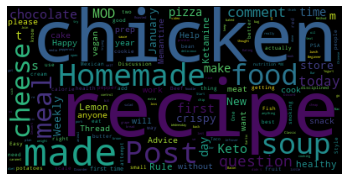

In [5]:
wordcloud2 = WordCloud().generate(' '.join(rslt_df_food['title']))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

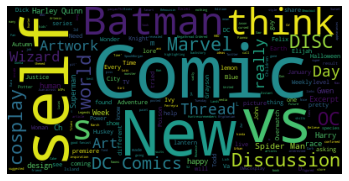

In [6]:
wordcloud2 = WordCloud().generate(' '.join(rslt_df_comics['title']))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

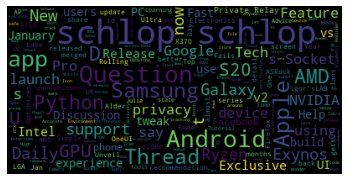

In [7]:
wordcloud2 = WordCloud().generate(' '.join(rslt_df_tech['title']))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

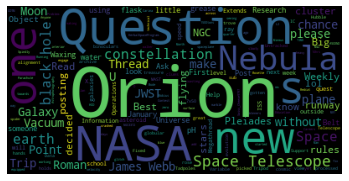

In [8]:
wordcloud2 = WordCloud().generate(' '.join(rslt_df_space['title']))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

__PREPROCESSING__

In [9]:
# removing everything except alphabets`
df['clean_doc'] = df['title'].str.replace("[^a-zA-Z#]", " ")
# removing null fields
df = df[df['clean_doc'].notnull()]
# removing short words
df['clean_doc'] = df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# make all text lowercase
df['clean_doc'] = df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-9-e4cdc9c278ad>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_doc'] = df['title'].str.replace("[^a-zA-Z#]", " ")


__EMBEDDINGS(TF-IDF)__

In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['like','january','thread','would','first','time','good', 'moderator', 'announcement','daily','discussion','baiting','titles','title','spam','upvote','allowed','know','make','best','weekly','think','year','years'])
# data is from washingtonpost, and it occurs heavily in every article, thus added to stop words
# tokenization
tokenized_doc = df['clean_doc'].apply(lambda x: x.split())
# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
#print(tokenized_doc)
# de-tokenization
detokenized_doc = []
for i in range(len(tokenized_doc)):
    if i in tokenized_doc:
        t = ' '.join(tokenized_doc[i])
        detokenized_doc.append(t)
#print(detokenized_doc)
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf vectorizer of scikit learn
vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=10000, max_df = 0.5, use_idf = True, ngram_range=(1,3))
X = vectorizer.fit_transform(detokenized_doc)
#print(X) # check shape of the document-term matrix
terms = vectorizer.get_feature_names()

__EMBEDDINGS(sentence transformers)__

In [11]:
model_bert = SentenceTransformer('all-mpnet-base-v2')
all_intents = list(df['clean_doc'])

In [12]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences, show_progress_bar=True)
    
    return embeddings

In [13]:
sentence_embeddings = embed(model_bert, 'sentence transformer', all_intents)

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

__EMBEDDINGS(FASTTEXT)__

In [14]:
model = fasttext.train_unsupervised('C:/Users/chait/Desktop/MT/wordembed.txt') 
f = []                                               
for i in df['clean_doc']:   
    f.append(model.get_sentence_vector(i))
w_train = np.array(f)    

# __KMEANS__

In [15]:
def plotkmeansalgo(embeddings, k_range):
    sse = []
    silhouette_avg_n_clusters = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
        kmeans.fit(embeddings)
        sse.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(embeddings, kmeans.predict(embeddings))
        silhouette_avg_n_clusters.append(silhouette_avg)

    # plot sse
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(k_range, sse)
    axes[0].set(xlabel = 'k clusters', ylabel = 'SSE', title = 'Elbow plot')
    axes[0].grid()
    
    # plot avg silhouette score
    axes[1].plot(k_range, silhouette_avg_n_clusters)
    axes[1].set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    axes[1].grid()

    plt.show()

In [16]:
def calculatetheclusterssize(embeddings, size_range):
    results = []
    
    for i in size_range:
        min_cluster_size = i
        
        clusters_hdbscan = (hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                           metric='euclidean', 
                                           cluster_selection_method='eom') 
                                           .fit(embeddings))
    
        labels = clusters_hdbscan.labels_
        label_count = len(np.unique(labels))
        
        total_num = len(clusters_hdbscan.labels_)
        cost = (np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)/total_num) 
                
        results.append([min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['min_cluster_size', 
                                               'label_count', 'noise'])
    
    return result_df

In [17]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=4, n_init=1)

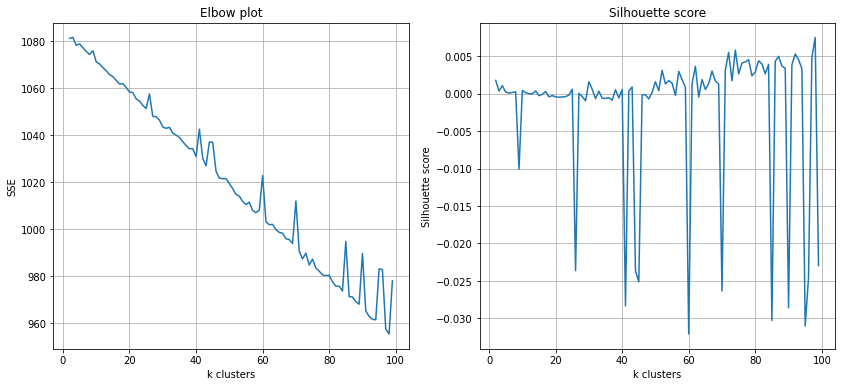

In [18]:
k_range = range(2, 100)
plotkmeansalgo(X, k_range)

In [19]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(sentence_embeddings)

KMeans(max_iter=100, n_clusters=4, n_init=1)

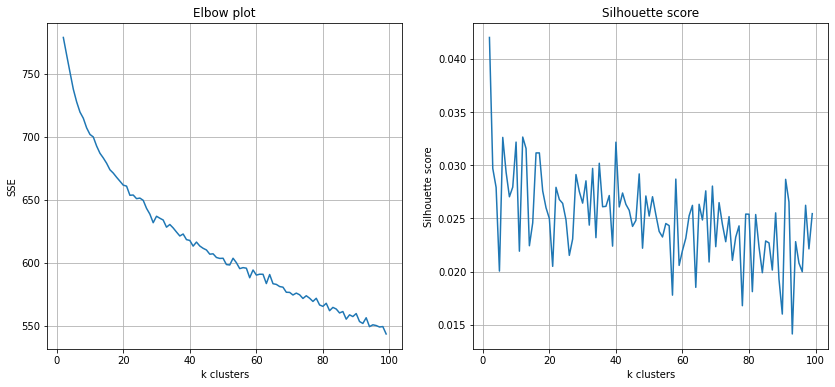

In [20]:
k_range = range(2, 100)
plotkmeansalgo(sentence_embeddings, k_range)

In [21]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(w_train)

KMeans(max_iter=100, n_clusters=4, n_init=1)

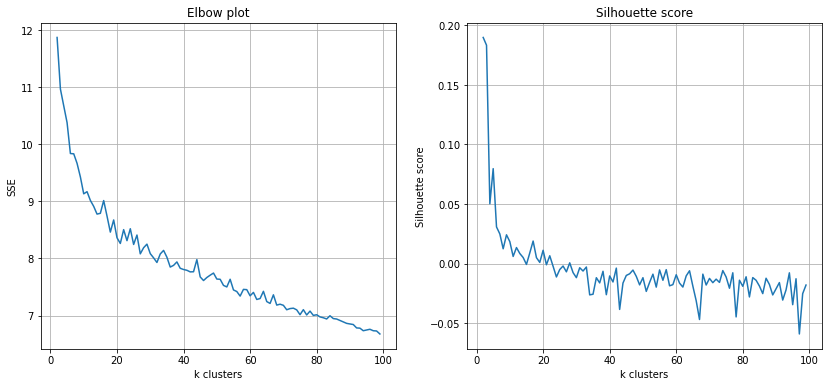

In [22]:
k_range = range(2, 100)
plotkmeansalgo(w_train, k_range)

## HDBSCAN WITHOUT TUNING

In [23]:
 clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=3, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(sentence_embeddings)

labels = clusters_hdbscan.labels_


In [24]:
size_range = range(2,11) 
calculatetheclusterssize(sentence_embeddings, size_range=size_range)

,min_cluster_size,label_count,noise
0,2,3,0.006387
1,3,3,0.434307
2,4,3,0.656934
3,5,3,0.669708
4,6,5,0.928832
5,7,3,0.924270
6,8,3,0.934307
7,9,3,0.945255
8,10,3,0.952555


## HDBSCAN WITH PARAMETER TUNING 

In [25]:
def generating_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [26]:
def label_clusters(clusters, prob_threshold = 0.05): 
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    return label_count, cost

In [27]:
def random_search(embeddings, space, num_evals):

    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        random_state = space['random_state']
        
        clusters = generating_clusters(embeddings, 
                                     n_neighbors=n_neighbors, 
                                     n_components=n_components, 
                                     min_cluster_size=min_cluster_size, 
                                     random_state=random_state)
    
        label_count, cost = label_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [28]:
def objective(params, embeddings, label_lower, label_upper): 
    clusters = generating_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = label_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [29]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generating_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [30]:
def combine_results(df_ground, cluster_dict):

    df_combined = df_ground.copy()
    
    for key, value in cluster_dict.items():
        df_combined[key] = value.labels_
    
    return df_combined

In [31]:
def summarize_results(results_dict, results_df):
  
    summary = []

    for key, value in results_dict.items():
        ground_label = results_df['category'].values
        predicted_label = results_df[value[0]].values
        
        ari = np.round(adjusted_rand_score(ground_label, predicted_label), 3)
        nmi = np.round(normalized_mutual_info_score(ground_label, predicted_label), 3)
        loss = value[2].best_trial['result']['loss']
        label_count = value[2].best_trial['result']['label_count']
        n_neighbors = value[1]['n_neighbors']
        n_components = value[1]['n_components']
        min_cluster_size = value[1]['min_cluster_size']
        random_state = value[1]['random_state']
        
        summary.append([key, ari, nmi, loss, label_count, n_neighbors, n_components, 
                        min_cluster_size, random_state])

    df_final = pd.DataFrame(summary, columns=['Model', 'ARI', 'NMI', 'loss', 
                                              'label_count', 'n_neighbors',
                                              'n_components', 'min_cluster_size',
                                              'random_state'])
    
    return df_final.sort_values(by='NMI', ascending=False)

In [32]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):

    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

__TF-IDF CLUSTERS__

In [33]:
clusters_default = generating_clusters(X, 
                                     n_neighbors = 15, 
                                     n_components = 5, 
                                     min_cluster_size = 10,
                                     random_state=42)
labels_def, cost_def = label_clusters(clusters_default)
print(labels_def)
print(cost_def)

17
0.5912408759124088


__Sentence Embedding CLUSTERS__

In [34]:
clusters_default_sentence = generating_clusters(sentence_embeddings, 
                                     n_neighbors = 15, 
                                     n_components = 5, 
                                     min_cluster_size = 10,
                                     random_state=42)
labels_def, cost_def = label_clusters(clusters_default_sentence)
print(labels_def)
print(cost_def)

20
0.36313868613138683


__FASTTEXT EMBEDDINGS CLUSTERS__

In [35]:
clusters_default_fast = generating_clusters(w_train, 
                                     n_neighbors = 15, 
                                     n_components = 5, 
                                     min_cluster_size = 10,
                                     random_state=42)
labels_def, cost_def = label_clusters(clusters_default_fast)
print(labels_def)
print(cost_def)

8
0.7700729927007299


__HYPERPARAMETER TUNING__

In [36]:
#tf-idf
space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use = random_search(X, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
random_use.head(15)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
37,37,13,3,13,3,0.230839
94,94,15,3,2,161,0.230839
75,75,13,3,13,3,0.230839
10,10,13,3,13,3,0.230839
79,79,14,5,2,137,0.245438
51,51,12,6,2,157,0.260036
95,95,13,6,2,148,0.276460
27,27,13,3,14,3,0.281934
52,52,13,3,3,88,0.298358
22,22,14,3,14,4,0.322080


In [38]:
space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use_fasttext = random_search(w_train, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
random_use_fasttext.head(15)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
27,27,12,4,4,3,0.057482
49,49,14,4,4,3,0.090328
16,16,15,4,5,3,0.187044
31,31,12,3,2,155,0.281022
41,41,12,3,8,3,0.295620
94,94,12,3,8,3,0.295620
73,73,15,3,2,150,0.298358
92,92,13,4,2,165,0.299270
32,32,14,5,8,3,0.351277
70,70,14,5,8,3,0.351277


In [40]:
#sentence
space = {
        "n_neighbors": range(12,16),
        "n_components": range(3,7),
        "min_cluster_size": range(2,16),
        "random_state": 42
    }

random_use_sentence = random_search(sentence_embeddings, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [41]:
random_use_sentence.head(15)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
33,33,13,3,12,9,0.159672
16,16,12,3,12,10,0.179745
11,11,12,3,12,10,0.179745
34,34,15,5,3,61,0.208029
43,43,12,3,13,9,0.209854
15,15,13,3,14,9,0.214416
23,23,15,4,2,136,0.217153
22,22,13,3,2,142,0.222628
90,90,15,3,3,77,0.228102
83,83,13,4,2,121,0.239051


## Bayesian optimization with Hyperopt   

In [42]:
hspace = {  
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "random_state": 42
}       

label_lower = 30
label_upper = 100
max_evals = 100

In [43]:
best_params_use, best_clusters_use, trials_use = bayesian_search(X, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [03:30<00:00,  2.11s/trial, best loss: 0.15456204379562044]
best:
{'min_cluster_size': 7, 'n_components': 15, 'n_neighbors': 3, 'random_state': 42}
label count: 3


In [44]:
best_params_st2, best_clusters_st2, trials_st2 = bayesian_search(sentence_embeddings, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [05:34<00:00,  3.35s/trial, best loss: 0.09762773722627738]
best:
{'min_cluster_size': 6, 'n_components': 3, 'n_neighbors': 3, 'random_state': 42}
label count: 41


In [45]:
best_params_st3, best_clusters_st3, trials_st3 = bayesian_search(w_train, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [04:38<00:00,  2.78s/trial, best loss: 0.15328467153284672]
best:
{'min_cluster_size': 3, 'n_components': 5, 'n_neighbors': 3, 'random_state': 42}
label count: 87


## visualize clusters


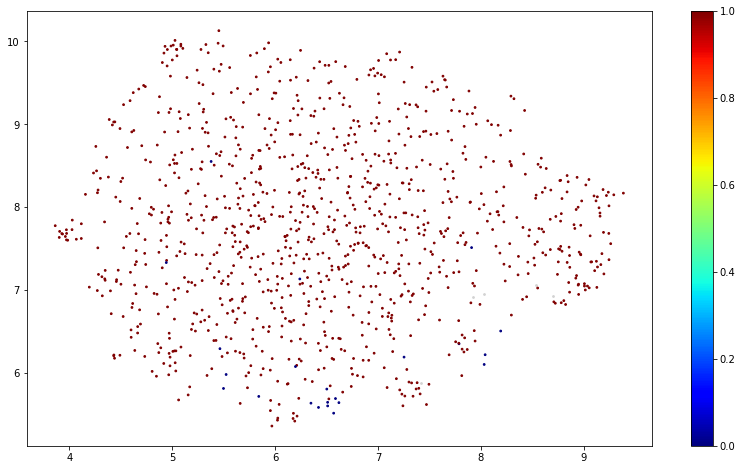

In [46]:
plot_clusters(X, best_clusters_use)

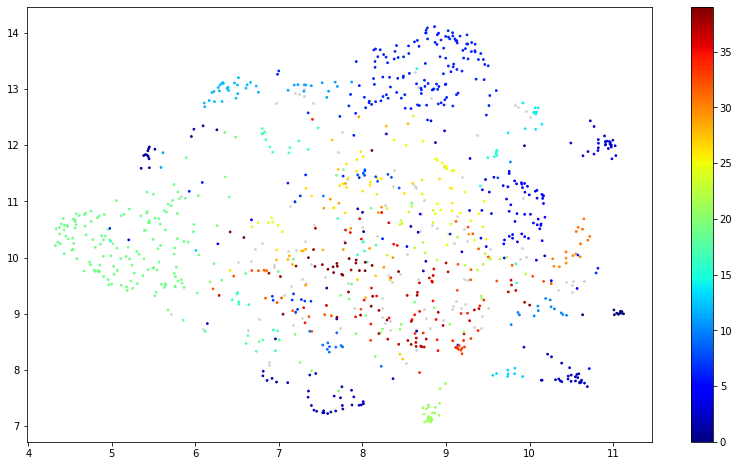

In [47]:
plot_clusters(sentence_embeddings, best_clusters_st2)

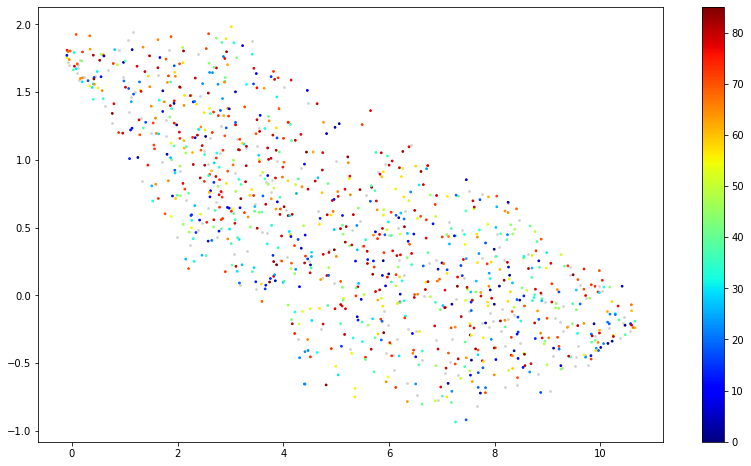

In [48]:
plot_clusters(w_train, best_clusters_st3)

## EVALUATION METRICS

In [64]:
cluster_dict = {'label_use': best_clusters_use,
                'label_st1': best_clusters_st2, 
               'label_st2':  best_clusters_st3}

results_df = combine_results(df[['title','category']], cluster_dict)   
#results_df.to_excel (r'C:/Users/chait/Desktop/Masterthesisgit/jugadfinal2.xlsx', index = False, header=True)

In [65]:
model_dict = {'tf-idf': ['label_use', best_params_use, trials_use],
              'sentence_transformers': ['label_st1', best_params_st2, trials_st2],
              'fasttext': ['label_st2', best_params_st3, trials_st3]}

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
1,sentence_transformers,0.451,0.708,0.097628,41,3,3,6,42
2,fasttext,0.002,0.206,0.153285,87,3,5,3,42
0,tf-idf,0.002,0.027,0.154562,3,3,15,7,42
